1. Preprocessor:    
    - Filtering
    - Augmentation in time domain
(still in dataframe)

2. Compression
    - Store the data in less bits (currently in 16bit)

In [3]:
# given
import struct
from pathlib import Path
# import RaggedArray type


BASE_DIR = Path().resolve()
data_path = BASE_DIR / "data"  # Directory to store data files
train_data_path = BASE_DIR / "data" / "X_train.bin"
test_data_path = BASE_DIR / "data" / "X_test.bin"
train_label_path = BASE_DIR / "data" / "y_train.csv"


def read_binary(path):
    ragged_array = []
    with open(path, "rb") as r:
        read_binary_from(ragged_array, r)
    return ragged_array


def read_binary_from(ragged_array, r):
    while True:
        size_bytes = r.read(4)
        if not size_bytes:
            break
        sub_array_size = struct.unpack("i", size_bytes)[0]
        sub_array = list(
            struct.unpack(f"{sub_array_size}h", r.read(sub_array_size * 2))
        )
        sub_array = [int(x) for x in sub_array]
        ragged_array.append(sub_array)

In [4]:
# find a lossless compression type for the data instead of 16bit (e.g., PDICT, PDELTA, PFOR).  --> then NS (null suppression)
import dask  # we will have a lot of for loops for each data point, so we will use dask to parallelize the process
import numpy as np
import bitstruct
import struct  

# before patched version
# Delta Encoding
def delta_encode(data):
    deltas = [data[0]]  # Store the first value
    for i in range(1, len(data)):
        deltas.append(data[i] - data[i - 1])
    return deltas


# Delta Decoding
def delta_decode(deltas):
    original = [deltas[0]]  # Start with the first value
    for i in range(1, len(deltas)):
        original.append(original[-1] + deltas[i])
    return original


def pack_offsets(offsets, bits_needed=12):
    fmt = f"u{bits_needed}"
    overall_fmt = fmt * len(offsets)
    packed = bitstruct.pack(overall_fmt, *offsets)
    return packed


def unpack_offsets(packed, bits_needed=12, num_values=None):
    fmt = f"u{bits_needed}"
    if num_values is None:
        raise ValueError("num_values must be provided")
    overall_fmt = fmt * num_values
    unpacked = bitstruct.unpack(overall_fmt, packed)
    return list(unpacked)


def for_encode(data: list) -> tuple:
    data_copy = data.copy()
    min_val = min(data)
    for i in range(len(data_copy)):
        data_copy[i] -= min_val
        if data_copy[i] < 0:
            print(f"data[i] is negative: {data_copy[i]} min_val: {min_val}")
    return min_val, data_copy


def for_decode(data: list, min_val: int) -> list:
    return [val + min_val for val in data]


def pfor_encode(data: list, patch_size: int = 128) -> tuple:
    patches = []
    min_vals = []
    max_all = 0
    bits_needed = 0
    for i in range(0, len(data), patch_size):
        patch = data[i : i + patch_size]
        min_val, encoded_patch = for_encode(patch)

        max_val = (
            max(encoded_patch) if encoded_patch else 0
        )  
        if max_val > max_all:
            bits_needed = (
                max_val.bit_length() if max_val > 0 else 1
            )  
            max_all = max_val
        patches.append(encoded_patch)
        min_vals.append(min_val)

    return patches, min_vals, bits_needed


def encoded_pfor_to_binary(signal_length, patches, min_vals, bits_needed=12) -> bytes:
    # first 32 bits for the length of the signal
    # second 32 bits for the bits needed
    # third 32 bits for the patch size

    patch_size = len(patches[0]) if patches else 0  
    header = struct.pack("III", signal_length, bits_needed, patch_size)
    # last patch length and num_patches can be inferred from the header data

    packed_patches = bytearray(header)
    for min_val, patch in zip(min_vals, patches):
        packed_patches.extend(struct.pack("h", min_val))
        packed_offsets = pack_offsets(patch, bits_needed)
        packed_patches.extend(packed_offsets)

    return bytes(packed_patches)


def signal_to_binary(signal, patch_size) -> bytes:
    signal_length = len(signal)
    patches, min_vals, bits_needed = pfor_encode(signal, patch_size)
    print(f"bits needed for this signal {bits_needed}")
    return encoded_pfor_to_binary(signal_length, patches, min_vals, bits_needed), bits_needed


def signals_to_binary(signals, patch_size) -> bytes:
    # header: # first 32 bits for the number of signals
    num_signals = len(signals)
    header = struct.pack("I", num_signals)

    binary_data, bits_needed = b"".join(
        signal_to_binary(signal, patch_size)[0] for signal in signals
    ), [signal_to_binary(signal, patch_size)[1] for signal in signals]
    return header + binary_data, bits_needed


def pfor_decode(patches) -> list: 
    decoded_data = []
    for min_val, patch in patches:
        decoded_patch = for_decode(patch, min_val)
        decoded_data.extend(decoded_patch)
    return decoded_data


def binary_to_decoded_pfor(binary_data: bytes, start_offset: int = 0) -> tuple:  
    header_size = 12  # 3 integers of 4 bytes each

    signal_length, bits_needed, patch_size = struct.unpack("III", binary_data[start_offset : start_offset + header_size])

    if patch_size == 0: 
        return [], header_size

    if signal_length == patch_size:
        num_patches = 1
    else:
        num_patches = (signal_length + patch_size - 1) // patch_size

    patches = []
    offset = start_offset + header_size

    for i in range(num_patches):
        min_val = struct.unpack("h", binary_data[offset : offset + 2])[0]
        offset += 2

        if i == num_patches - 1:
            num_values = signal_length - (num_patches - 1) * patch_size
            if num_values <= 0:
                raise ValueError("Invalid number of values in the last patch")
        else:
            num_values = patch_size

        patch_length = (num_values * bits_needed + 7) // 8
        packed_offsets = binary_data[offset : offset + patch_length]
        offsets = unpack_offsets(packed_offsets, bits_needed, num_values)
        offset += patch_length

        patches.append((min_val, offsets))

    decoded_data = pfor_decode(patches)
    bytes_consumed = offset - start_offset  # it's way easier this way
    return decoded_data, bytes_consumed


def binary_to_signals(binary_data: bytes) -> list:
    header_size = 4  # 1 integer of 4 bytes ---> just to signal when to stop, could be removed
    (num_signals,) = struct.unpack("I", binary_data[:header_size])
    offset = header_size
    signals = []

    for _ in range(num_signals):
        signal, bytes_consumed = binary_to_decoded_pfor(binary_data, offset)  
        signals.append(signal)
        offset += bytes_consumed  

    return signals


def test_roundtrip():

    original_signal = [100, 102, 105, 103, 108, 110, 107, 112]
    patch_size = 512
    binary = signal_to_binary(original_signal, patch_size)
    decoded_signal, _ = binary_to_decoded_pfor(binary)

    print(f"Original: {original_signal}")
    print(f"Decoded:  {decoded_signal}")
    print(f"Match: {original_signal == decoded_signal}")


    original_signals = [
        [i for i in range(rand_length)] for rand_length in range(2000, 9000, 500)
    ]
    
    # write original_signals to a file
    with open("original_signals.bin", "wb") as f:
        for signal in original_signals:
            f.write(struct.pack("I", len(signal)))
            f.write(struct.pack(f"{len(signal)}h", *signal))


    original_signals_read = read_binary("original_signals.bin")
    assert original_signals_read == original_signals

    print(f"Size of original signals file: {Path('original_signals.bin').stat().st_size} bytes")

    binary = signals_to_binary(original_signals, patch_size)
    print(f"Size of binary {len(binary)} bytes")
    with open("encoded_signals.bin", "wb") as f:
        f.write(binary)

    print(f"Size of encoded signals file: {Path('encoded_signals.bin').stat().st_size} bytes")
    decoded_signals = binary_to_signals(binary)

    print(f"\nMultiple signals test:")
    print(f"Original: {original_signals}")
    print(f"Decoded:  {decoded_signals}")
    print(f"Match: {original_signals == decoded_signals}")


if __name__ == "__main__":
    test_roundtrip()

bits needed for this signal 4


TypeError: a bytes-like object is required, not 'tuple'

In [5]:
# test binary conversion
import pandas as pd

print(f"Size of original signals file: {train_data_path.stat().st_size} bytes")
signals = read_binary(train_data_path)  

binary, bits_used = signals_to_binary(signals, patch_size=512)

binary_length = len(binary)
print(f"Size of encoded signals file: {binary_length} bytes")
with open("encoded_signals.bin", "wb") as f:
    f.write(binary)

binary_file_size = Path("encoded_signals.bin").stat().st_size
print(f"Size of encoded signals file: {binary_file_size} bytes")
decoded_signals = binary_to_signals(binary)
print(f"Decoded signals length: {len(decoded_signals)}")
assert signals == decoded_signals, "Decoded signals do not match original"

compression_ratio = binary_length / train_data_path.stat().st_size
print(f"Compression ratio: {compression_ratio:.2f}")



Size of original signals file: 120641086 bytes
bits needed for this signal 10
bits needed for this signal 11
bits needed for this signal 11
bits needed for this signal 13
bits needed for this signal 11
bits needed for this signal 11
bits needed for this signal 10
bits needed for this signal 12
bits needed for this signal 12
bits needed for this signal 11
bits needed for this signal 11
bits needed for this signal 10
bits needed for this signal 10
bits needed for this signal 11
bits needed for this signal 12
bits needed for this signal 11
bits needed for this signal 11
bits needed for this signal 12
bits needed for this signal 12
bits needed for this signal 11
bits needed for this signal 11
bits needed for this signal 11
bits needed for this signal 11
bits needed for this signal 10
bits needed for this signal 11
bits needed for this signal 12
bits needed for this signal 11
bits needed for this signal 12
bits needed for this signal 10
bits needed for this signal 12
bits needed for this si

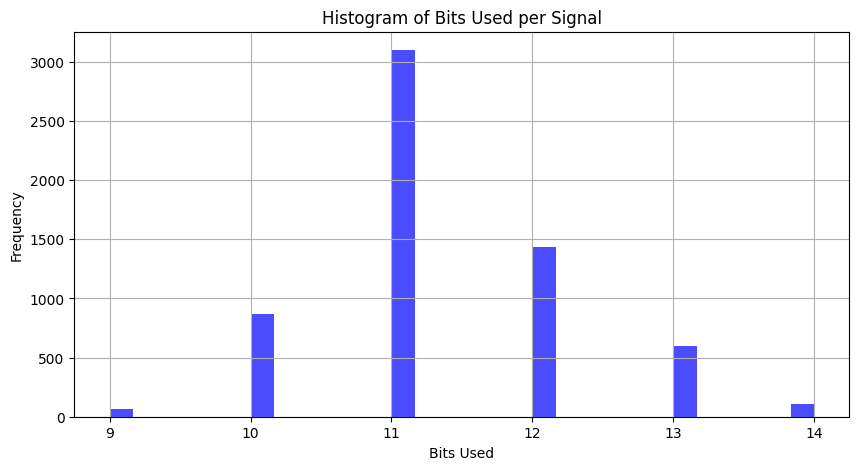

In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(bits_used, bins=30, color="blue", alpha=0.7)
plt.title("Histogram of Bits Used per Signal")
plt.xlabel("Bits Used")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()